# 11. Simple CNN

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.utils.data as Data

import numpy as np
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 11.1 Prepare Custom Data

In [3]:
img_dir = "./data/jamo"
img_data = dsets.ImageFolder(img_dir, transforms.Compose([
            transforms.Grayscale(),
            transforms.ToTensor(),
            ]))

#https://pytorch.org/docs/stable/torchvision/transforms.html

print(img_data.classes)
print(img_data.class_to_idx)

['ㄱ', 'ㄲ', 'ㄴ', 'ㄷ', 'ㄸ', 'ㄹ', 'ㅁ', 'ㅂ', 'ㅃ', 'ㅅ', 'ㅆ', 'ㅇ', 'ㅈ', 'ㅉ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ', 'ㅏ', 'ㅐ', 'ㅑ', 'ㅒ', 'ㅓ', 'ㅔ', 'ㅕ', 'ㅖ', 'ㅗ', 'ㅘ', 'ㅙ', 'ㅛ', 'ㅜ', 'ㅝ', 'ㅞ', 'ㅟ', 'ㅠ', 'ㅡ', 'ㅢ', 'ㅣ']
{'ㄱ': 0, 'ㄲ': 1, 'ㄴ': 2, 'ㄷ': 3, 'ㄸ': 4, 'ㄹ': 5, 'ㅁ': 6, 'ㅂ': 7, 'ㅃ': 8, 'ㅅ': 9, 'ㅆ': 10, 'ㅇ': 11, 'ㅈ': 12, 'ㅉ': 13, 'ㅊ': 14, 'ㅋ': 15, 'ㅌ': 16, 'ㅍ': 17, 'ㅎ': 18, 'ㅏ': 19, 'ㅐ': 20, 'ㅑ': 21, 'ㅒ': 22, 'ㅓ': 23, 'ㅔ': 24, 'ㅕ': 25, 'ㅖ': 26, 'ㅗ': 27, 'ㅘ': 28, 'ㅙ': 29, 'ㅛ': 30, 'ㅜ': 31, 'ㅝ': 32, 'ㅞ': 33, 'ㅟ': 34, 'ㅠ': 35, 'ㅡ': 36, 'ㅢ': 37, 'ㅣ': 38}


In [4]:
batch_size = 100

In [5]:
def train_test_split(data, train_ratio, batch_size, stratify) :
    
    length = len(data)
    
    cut = int(len(data)*train_ratio)
    train_indices = np.random.shuffle(np.random.permutation(np.arange(length))[:cut])
    test_indices = np.random.shuffle(np.random.permutation(np.arange(length))[cut:])
        
    if stratify :
        
        count = [0]*len(img_data.classes)
        for _, label in img_data :
            count[label] += 1

        weight = []    
        for i, (_, label) in enumerate(img_data) :
            weight.append(1/ count[label])
        weight = np.array(weight)
        
        train_indices = np.random.choice(length, cut, p=weight/sum(weight), replace=False)
        test_indices = np.array(list(set(range(length)) - set(train_indices)))
        
    train_loader = Data.DataLoader(data, batch_size=batch_size, shuffle=False, sampler = torch.utils.data.SubsetRandomSampler(train_indices), drop_last = True)
    test_loader = Data.DataLoader(data, batch_size=batch_size, shuffle=False, sampler = torch.utils.data.SubsetRandomSampler(test_indices), drop_last = True)

    return train_loader, test_loader, len(train_indices), len(test_indices)

In [6]:
train_loader, test_loader, train_num, test_num = train_test_split(img_data, 0.8, batch_size, True)

In [7]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

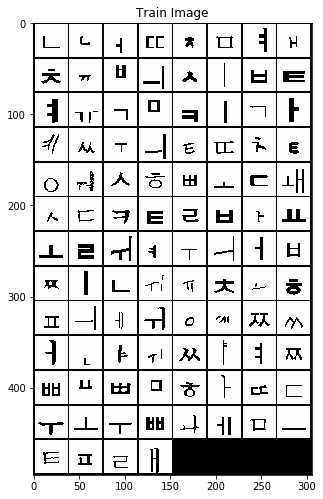

In [8]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

In [9]:
images.shape, labels[0:5]

(torch.Size([100, 1, 36, 36]), tensor([ 2,  2, 23,  4, 14]))

## 11.2 Define Model

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1,16,5), # 16 * 32 * 32
            nn.ReLU(),
            nn.Conv2d(16,32,5), # 32 * 28 * 28
            nn.ReLU(),
            nn.MaxPool2d(2,2) # 32 * 14 * 14
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(32*14*14, 39)
        ) 
        
    def forward(self,x):
        out = self.conv_layer(x)
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)

        return out

In [11]:
model = CNN().cuda()

In [12]:
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

## 11.3 Train Model

In [13]:
num_epochs = 5

In [14]:
for epoch in range(num_epochs):

    for i, (batch_images, batch_labels) in enumerate(train_loader):

        X = batch_images.cuda()
        Y = batch_labels.cuda()

        pre = model(X)
        cost = loss(pre, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, train_num//batch_size, cost.item()))

Epoch [1/5], lter [100/224], Loss: 3.6500
Epoch [1/5], lter [200/224], Loss: 3.6528
Epoch [2/5], lter [100/224], Loss: 3.6331
Epoch [2/5], lter [200/224], Loss: 3.6210
Epoch [3/5], lter [100/224], Loss: 3.6032
Epoch [3/5], lter [200/224], Loss: 3.5773
Epoch [4/5], lter [100/224], Loss: 3.5408
Epoch [4/5], lter [200/224], Loss: 3.5048
Epoch [5/5], lter [100/224], Loss: 3.4301
Epoch [5/5], lter [200/224], Loss: 3.3682


## 11.4 Test Model

In [15]:
model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    
    images = images.cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

Accuracy of test images: 41.428571 %
